C:\Users\iamga\AppData\Local\Temp\ipykernel_144596\1740604225.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_B = np.trapz(B, t)


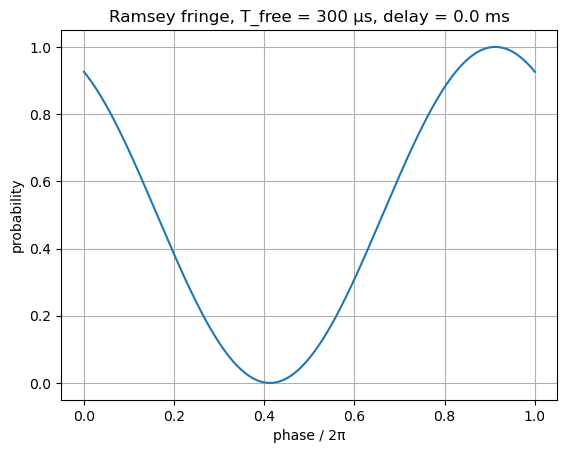

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def level_phases_from_line(t_start, T_free, sensitivities_MHz_per_G, line_func, field_scale_to_G=1.0, n_steps=2000):
    t = t_start + np.linspace(0.0, T_free, n_steps)
    B = line_func(t)
    integral_B = np.trapz(B, t)
    phases = 2 * np.pi * sensitivities_MHz_per_G * 1e6 * field_scale_to_G * integral_B
    return phases

def transition_phase_from_line(t_start, T_free, idx_i, idx_j, sensitivities_MHz_per_G, line_func, field_scale_to_G=1.0, n_steps=2000):
    phases_levels = level_phases_from_line(t_start, T_free, sensitivities_MHz_per_G, line_func, field_scale_to_G, n_steps)
    return phases_levels[idx_j] - phases_levels[idx_i]

def ramsey_excited_population(phi_ctrl, phi_B):
    return 0.5 * (1.0 + np.cos(phi_ctrl + phi_B))

def ramsey_fringe_for_transition(t_start, T_free, idx_i, idx_j, sensitivities_MHz_per_G, line_func, n_phase=200, field_scale_to_G=1.0):
    phi_B = transition_phase_from_line(t_start, T_free, idx_i, idx_j, sensitivities_MHz_per_G, line_func, field_scale_to_G)
    phases = np.linspace(0.0, 2.0 * np.pi, n_phase)
    pops = ramsey_excited_population(phases, phi_B)
    return phases, pops, phi_B
def line_signal(t, 
                A1=0.000309, phi1=-0.613928,
                A2=0.000067, phi2=4.479853,
                offset=0.000253):
    return (
        2*np.pi*A1 * np.sin(2 * np.pi * 60 * t + phi1) +
        2*np.pi*A2 * np.sin(2 * np.pi * 180 * t + phi2) +
        offset
    ) - (
        2*np.pi*A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
        2*np.pi*A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
        offset
    )
def example_run():
    sensitivities_MHz_per_G = np.array([0.0, 1.0])
    idx_i = 0
    idx_j = 1
    pi_time = 23e-6
    T_free = 300e-6
    delay_after_trigger = 0.0e-3
    line_period = 1.0 / 60.0
    t_start = delay_after_trigger
    phases, pops, phi_B = ramsey_fringe_for_transition(
        t_start=t_start,
        T_free=T_free,
        idx_i=idx_i,
        idx_j=idx_j,
        sensitivities_MHz_per_G=sensitivities_MHz_per_G,
        line_func=line_signal,
        n_phase=300,
        field_scale_to_G=3.5
    )
    plt.figure()
    plt.plot(phases / (2 * np.pi), pops)
    plt.xlabel("phase / 2π")
    plt.ylabel("probability")
    plt.title(f"Ramsey fringe, T_free = {T_free*1e6:.0f} µs, delay = {delay_after_trigger*1e3:.1f} ms")
    plt.grid(True)
    plt.show()
    return phases, pops, phi_B


phases, pops, phi_B = example_run()


C:\Users\iamga\AppData\Local\Temp\ipykernel_144596\3194821307.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  phases = np.trapz(omega_levels, t_grid, axis=1)


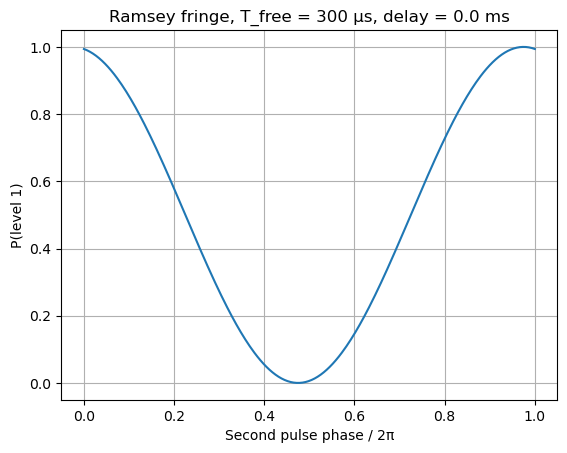

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def qudit_free_evolution_phases(t_start, T_free, sensitivities_MHz_per_G, line_func, field_scale_to_G=1.0, n_steps=2000):
    d = len(sensitivities_MHz_per_G)
    t_grid = np.linspace(t_start, t_start + T_free, n_steps)
    B_vals = line_func(t_grid) * field_scale_to_G
    omega_levels = 2 * np.pi * sensitivities_MHz_per_G[:, None] * 1e6 * B_vals[None, :]
    phases = np.trapz(omega_levels, t_grid, axis=1)
    return phases

def embed_two_level_unitary(U_2, dim, idx_i, idx_j):
    U = np.eye(dim, dtype=complex)
    U_block = U[np.ix_([idx_i, idx_j], [idx_i, idx_j])]
    U_block[:] = U_2
    U[np.ix_([idx_i, idx_j], [idx_i, idx_j])] = U_block
    return U

def two_level_pulse(theta, phase, dim, idx_i, idx_j):
    c = np.cos(theta / 2)
    s = np.sin(theta / 2)
    U2 = np.zeros((2, 2), dtype=complex)
    U2[0, 0] = c
    U2[1, 1] = c
    U2[0, 1] = -1j * s * np.exp(-1j * phase)
    U2[1, 0] = -1j * s * np.exp(+1j * phase)
    return embed_two_level_unitary(U2, dim, idx_i, idx_j)

def ramsey_fringe_qudit(
    sensitivities_MHz_per_G,
    line_func,
    idx_i,
    idx_j,
    T_free,
    delay_after_trigger,
    phases_ctrl,
    field_scale_to_G=1.0,
    n_steps_free=2000
):
    d = len(sensitivities_MHz_per_G)
    t_start = delay_after_trigger
    phases_levels = qudit_free_evolution_phases(
        t_start,
        T_free,
        sensitivities_MHz_per_G,
        line_func,
        field_scale_to_G=field_scale_to_G,
        n_steps=n_steps_free
    )
    U_free_diag = np.exp(-1j * phases_levels)
    U_free = np.diag(U_free_diag)
    state0 = np.zeros(d, dtype=complex)
    state0[idx_i] = 1.0
    U_pi2_first = two_level_pulse(theta=np.pi/2, phase=0.0, dim=d, idx_i=idx_i, idx_j=idx_j)
    pops_j = np.zeros_like(phases_ctrl, dtype=float)
    for k, phi_ctrl in enumerate(phases_ctrl):
        U_pi2_second = two_level_pulse(theta=np.pi/2, phase=phi_ctrl, dim=d, idx_i=idx_i, idx_j=idx_j)
        psi = state0.copy()
        psi = U_pi2_first @ psi
        psi = U_free @ psi
        psi = U_pi2_second @ psi
        pops_j[k] = np.abs(psi[idx_j])**2
    phase_shift = phases_levels[idx_j] - phases_levels[idx_i]
    return pops_j, phase_shift

def example_run():
    d = 2
    sensitivities_MHz_per_G = np.array([0.0, 1.0])
    idx_i = 0
    idx_j = 1
    T_free = 300e-6
    delay_after_trigger = 0e-3
    phases_ctrl = np.linspace(0.0, 2 * np.pi, 300)
    pops_j, phase_shift = ramsey_fringe_qudit(
        sensitivities_MHz_per_G=sensitivities_MHz_per_G,
        line_func=line_signal,
        idx_i=idx_i,
        idx_j=idx_j,
        T_free=T_free,
        delay_after_trigger=delay_after_trigger,
        phases_ctrl=phases_ctrl,
        field_scale_to_G=1.0,
        n_steps_free=4000
    )
    plt.figure()
    plt.plot(phases_ctrl / (2 * np.pi), pops_j)
    plt.xlabel("Second pulse phase / 2π")
    plt.ylabel(f"P(level {idx_j})")
    plt.title(f"Ramsey fringe, T_free = {T_free*1e6:.0f} µs, delay = {delay_after_trigger*1e3:.1f} ms")
    plt.grid(True)
    plt.show()
    return phases_ctrl, pops_j, phase_shift

if __name__ == "__main__":
    phases_ctrl, pops_j, phase_shift = example_run()
